In [1]:
!pip install -q fuzzywuzzy
!pip install scikit-surprise
!pip install python-Levenshtein

In [2]:
import numpy as np
import pandas as pd

from typing import List, Dict
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import fuzz

from surprise import SVD
from surprise import Dataset, Reader
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate

import warnings
warnings.filterwarnings('ignore')

In [3]:
songs_meta =  pd.read_csv("C:\\Users\\HP\\Desktop\\Datasets\\song_data.csv")
songs_meta.drop_duplicates(subset='song_id', inplace=True)
songs_meta.head()

,song_id,title,release,artist_name,year
0,SOQMMHC12AB0180CB8,Silent Night,Monster Ballads X-Mas,Faster Pussy cat,2003
1,SOVFVAK12A8C1350D9,Tanssi vaan,Karkuteillä,Karkkiautomaatti,1995
2,SOGTUKN12AB017F4F1,No One Could Ever,Butter,Hudson Mohawke,2006
3,SOBNYVR12A8C13558C,Si Vos Querés,De Culo,Yerba Brava,2003
4,SOHSBXH12A8C13B0DF,Tangle Of Aspens,Rene Ablaze Presents Winter Sessions,Der Mystic,0


In [4]:
interactions = pd.read_csv("C:\\Users\\HP\\Desktop\\Datasets\\triplets_file.csv")
interactions.drop_duplicates(subset=['song_id','user_id'], inplace=True, keep='last')
interactions.head()

,user_id,song_id,listen_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1


In [5]:
listen_counts = interactions.groupby('song_id', as_index=False)['listen_count'].sum()
songs_meta = pd.merge(songs_meta, listen_counts, on="song_id", how="left")
songs_meta.head()

,song_id,title,release,artist_name,year,listen_count
0,SOQMMHC12AB0180CB8,Silent Night,Monster Ballads X-Mas,Faster Pussy cat,2003,NaN
1,SOVFVAK12A8C1350D9,Tanssi vaan,Karkuteillä,Karkkiautomaatti,1995,NaN
2,SOGTUKN12AB017F4F1,No One Could Ever,Butter,Hudson Mohawke,2006,NaN
3,SOBNYVR12A8C13558C,Si Vos Querés,De Culo,Yerba Brava,2003,NaN
4,SOHSBXH12A8C13B0DF,Tangle Of Aspens,Rene Ablaze Presents Winter Sessions,Der Mystic,0,NaN


In [6]:
songs_meta.shape

(999056, 6)

In [7]:
songs_meta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999056 entries, 0 to 999055
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   song_id       999056 non-null  object 
 1   title         999041 non-null  object 
 2   release       999051 non-null  object 
 3   artist_name   999056 non-null  object 
 4   year          999056 non-null  int64  
 5   listen_count  10000 non-null   float64
dtypes: float64(1), int64(1), object(4)
memory usage: 53.4+ MB


In [8]:
songs_meta.describe()

,year,listen_count
count,999056.000000,10000.000000
mean,1029.688740,609.096900
std,998.762408,1401.268442
min,0.000000,71.000000
25%,0.000000,221.000000
50%,1969.000000,336.000000
75%,2002.000000,587.000000
max,2011.000000,54136.000000


In [9]:
songs_meta.describe(include=['O'])

,song_id,title,release,artist_name
count,999056,999041,999051,999056
unique,999056,702350,149211,72652
top,SOQMMHC12AB0180CB8,Intro,Greatest Hits,Johnny Cash
freq,1,1510,2002,191


In [10]:
songs_meta.isnull().sum()

song_id              0
title               15
release              5
artist_name          0
year                 0
listen_count    989056
dtype: int64

In [11]:
songs_meta['title'].fillna("Unknown", inplace=True)

# replacing NA release with 'Unknown' string
songs_meta['release'].fillna("Unknown", inplace=True)

# replacing NA listen counts with 0 integer
songs_meta['listen_count'].fillna(0, inplace=True)

# rechecking the status of missing values
songs_meta.isnull().sum()

song_id         0
title           0
release         0
artist_name     0
year            0
listen_count    0
dtype: int64

In [12]:
ten_pop_songs = songs_meta.sort_values(['listen_count', 'title'], ascending = [0,1])
ten_pop_songs['percentage']  = round(ten_pop_songs['listen_count'].div(ten_pop_songs['listen_count'].sum())*100, 2)
ten_pop_songs = ten_pop_songs[:10]
ten_pop_songs

,song_id,title,release,artist_name,year,listen_count,percentage
448642,SOBONKR12A58A7A7E0,You're The One,If There Was A Way,Dwight Yoakam,1990,54136.0,0.89
111083,SOAUWYT12A81C206F1,Undo,Vespertine Live,Björk,2001,49253.0,0.81
864901,SOSXLTC12AF72A7F54,Revelry,Only By The Night,Kings Of Leon,2008,41418.0,0.68
618270,SOEGIYH12A6D4FC0E3,Horn Concerto No. 4 in E flat K495: II. Romanc...,Mozart - Eine kleine Nachtmusik,Barry Tuckwell/Academy of St Martin-in-the-Fie...,0,31153.0,0.51
807573,SOFRQTD12A81C233C0,Sehr kosmisch,Musik von Harmonia,Harmonia,0,31036.0,0.51
151684,SOAXGDH12A8C13F8A1,Dog Days Are Over (Radio Edit),Now That's What I Call Music! 75,Florence + The Machine,0,26663.0,0.44
862476,SONYKOW12AB01849C9,Secrets,Waking Up,OneRepublic,2009,22100.0,0.36
282220,SOPUCYA12A8C13A694,Canada,The End Is Here,Five Iron Frenzy,0,21019.0,0.35
419122,SOUFTBI12AB0183F65,Invalid,Fermi Paradox,Tub Ring,2002,19645.0,0.32
201840,SOVDSJC12A58A7A271,Ain't Misbehavin,Summertime,Sam Cooke,0,18309.0,0.30


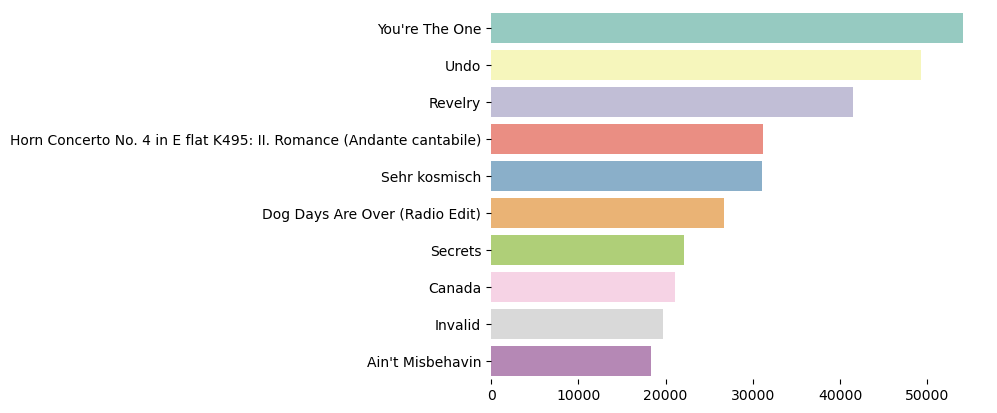

In [13]:
labels = ten_pop_songs['title'].tolist()
counts = ten_pop_songs['listen_count'].tolist()

plt.figure()
sns.barplot(x=counts, y=labels, palette='Set3')
sns.despine(left=True, bottom=True)

In [14]:
ten_pop_artists  = songs_meta.groupby(['artist_name'])['listen_count'].sum().reset_index().sort_values(['listen_count', 'artist_name'], ascending = [0,1])
ten_pop_artists = ten_pop_artists[:10]
ten_pop_artists

,artist_name,listen_count
12542,Coldplay,70138.0
34718,Kings Of Leon,68570.0
22312,Florence + The Machine,60066.0
18798,Dwight Yoakam,54136.0
7237,Björk,53814.0
62075,The Black Keys,52220.0
29137,Jack Johnson,44083.0
33129,Justin Bieber,41645.0
47228,OneRepublic,40981.0
67782,Train,39279.0


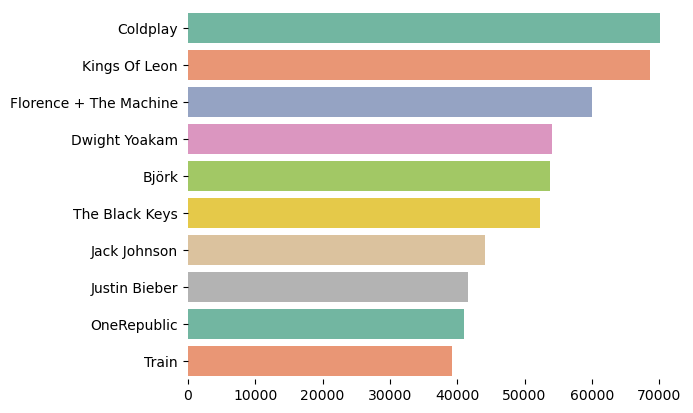

In [15]:
plt.figure()
labels = ten_pop_artists['artist_name'].tolist()
counts = ten_pop_artists['listen_count'].tolist()
sns.barplot(x=counts, y=labels, palette='Set2')
sns.despine(left=True, bottom=True)

In [16]:
interactions[interactions.listen_count==interactions.listen_count.max()]

,user_id,song_id,listen_count
1228366,d13609d62db6df876d3cc388225478618bb7b912,SOFCGSE12AF72A674F,2213


In [17]:
interactions.listen_count.mean()

3.0454845

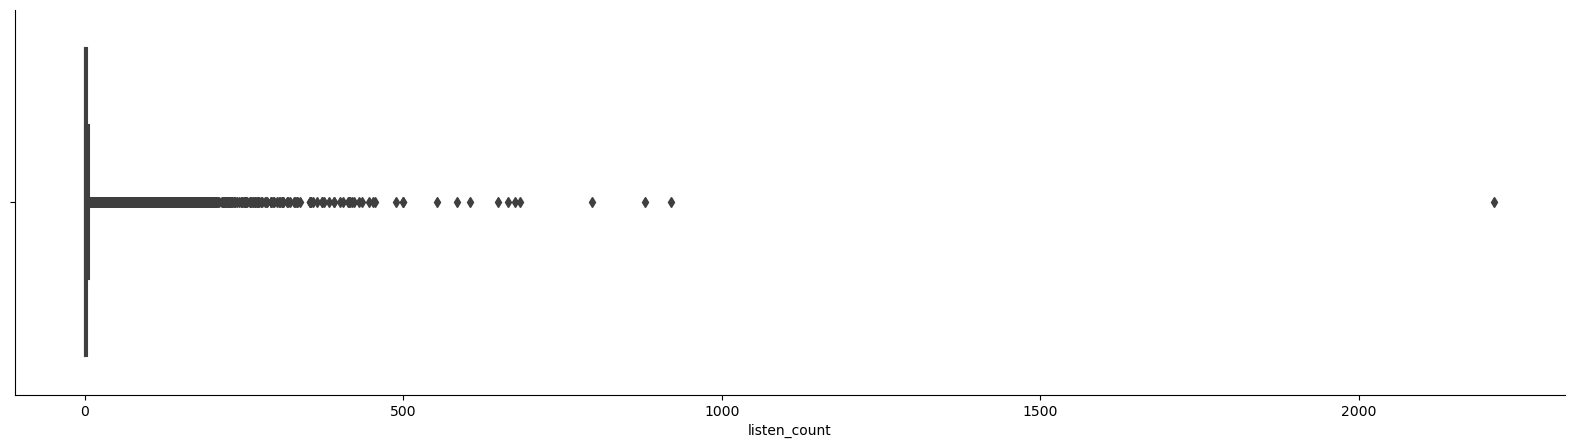

In [18]:
plt.figure(figsize=(20, 5))
sns.boxplot(x='listen_count', data=interactions)
sns.despine()

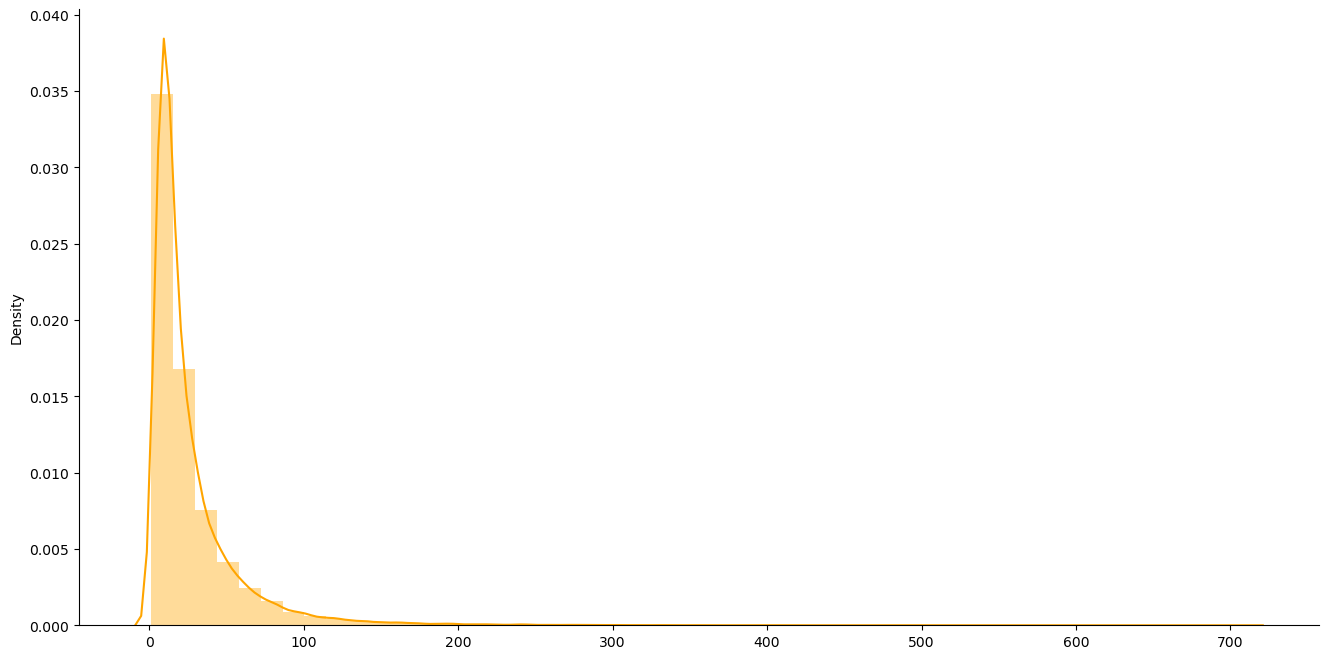

In [19]:
song_user = interactions.groupby('user_id')['song_id'].count()

plt.figure(figsize=(16, 8))
sns.distplot(song_user.values, color='orange')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show();

In [20]:
filter_song_ids = song_user[song_user > 16].index.to_list()
filter_song_df = interactions[interactions['user_id'].isin(filter_song_ids)].reset_index(drop=True)

# convert the dataframe into a pivot table
df_songs_features = filter_song_df.pivot(index='song_id', columns='user_id', values='listen_count').fillna(0)

# obtain a sparse matrix
mat_songs_features = csr_matrix(df_songs_features.values)

In [28]:
df_songs_features.values

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [27]:
print(mat_songs_features)

  (0, 190)	2.0
  (0, 1010)	1.0
  (0, 1991)	1.0
  (0, 3712)	1.0
  (0, 4160)	5.0
  (0, 6838)	3.0
  (0, 7049)	35.0
  (0, 7493)	1.0
  (0, 8003)	1.0
  (0, 8558)	12.0
  (0, 9055)	5.0
  (0, 9583)	1.0
  (0, 9798)	14.0
  (0, 9936)	1.0
  (0, 10080)	20.0
  (0, 10185)	1.0
  (0, 10308)	1.0
  (0, 10945)	3.0
  (0, 11878)	1.0
  (0, 11941)	1.0
  (0, 12454)	1.0
  (0, 15590)	6.0
  (0, 16468)	1.0
  (0, 16706)	3.0
  (0, 16938)	1.0
  :	:
  (9999, 19815)	1.0
  (9999, 20472)	1.0
  (9999, 20686)	3.0
  (9999, 21682)	1.0
  (9999, 22553)	1.0
  (9999, 24944)	4.0
  (9999, 25807)	1.0
  (9999, 26371)	2.0
  (9999, 26526)	1.0
  (9999, 26908)	1.0
  (9999, 26949)	1.0
  (9999, 27673)	4.0
  (9999, 28290)	1.0
  (9999, 29879)	1.0
  (9999, 30265)	2.0
  (9999, 31495)	5.0
  (9999, 32856)	3.0
  (9999, 32891)	6.0
  (9999, 33159)	6.0
  (9999, 33943)	1.0
  (9999, 35745)	2.0
  (9999, 36054)	1.0
  (9999, 36166)	3.0
  (9999, 36290)	5.0
  (9999, 36379)	1.0


In [21]:
df_songs_features.iloc[:10, :10]

user_id,000e2c2a8c7870ff9121f212b35c8b3a20cc0e67,000ebc858861aca26bac9b49f650ed424cf882fc,000ef25cc955ad5841c915d269432eea41f4a1a5,0012bf75d43a724f62dc746d9e85ae0088a3a1d6,001322829b5dc3edc59bf78189617ddd8f23c82a,00185e316f07f0f00c325ca034be59c15b362401,0019740e3e8c24e223a6f88e3faa7c144ec5a014,001b005fe5e80d3cb45f320f5658fc8e2e72794e,001f22c638730aed5659034c447d3cf0e658898e,0021d9a4628624f6d70237f9c200ab82e766bf26
song_id,,,,,,,,,,
SOAAAGQ12A8C1420C8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOAACPJ12A81C21360,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOAACSG12AB018DC80,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOAAEJI12AB0188AB5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOAAFAC12A67ADF7EB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOAAFYH12A8C13717A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOAAJMQ12A6D4F7D17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOAAKPM12A58A77210,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOAALWN12A6D4F7FDA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


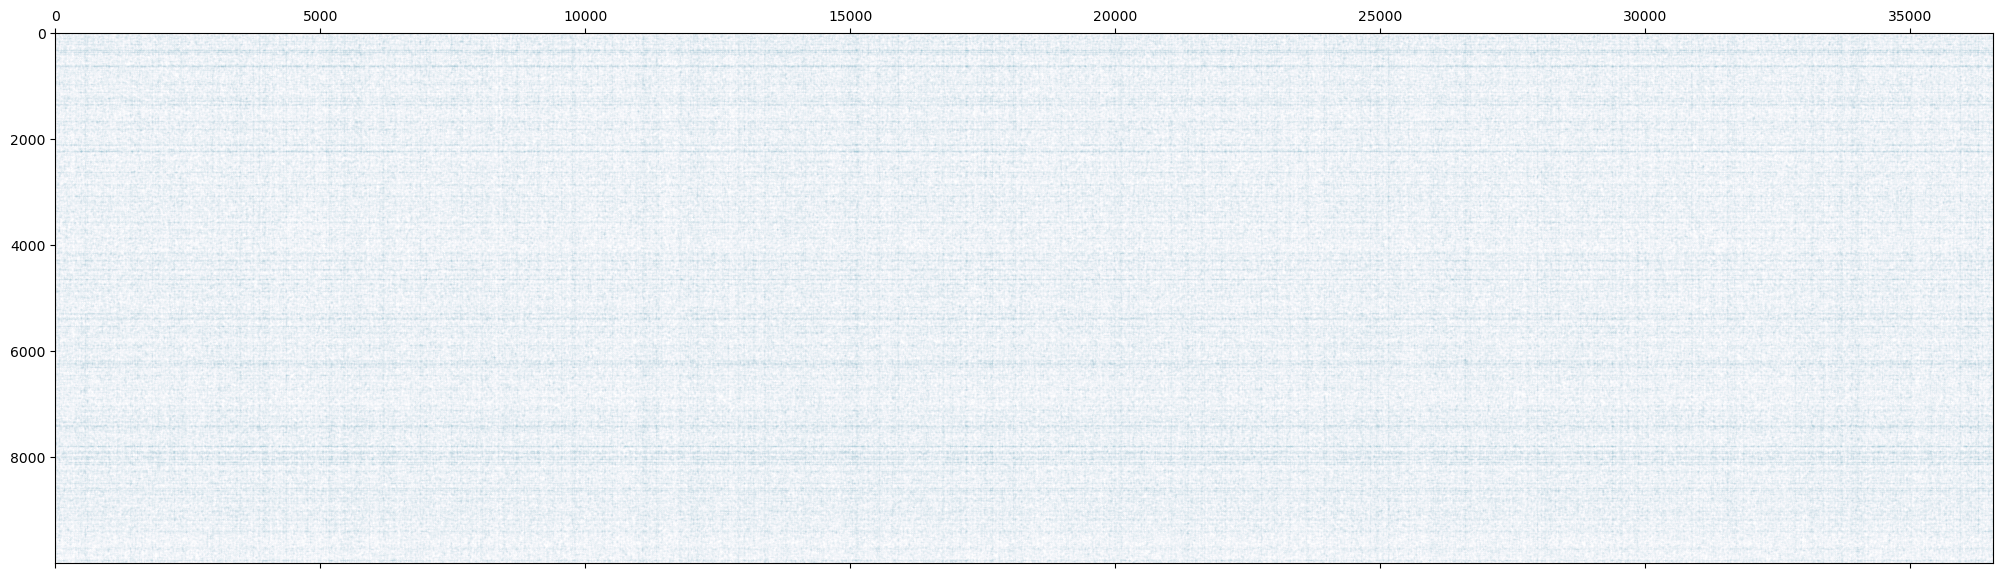

In [22]:
plt.figure(figsize=(25, 25))
plt.spy(mat_songs_features, markersize=0.005);

In [33]:
df_unique_songs = songs_meta.drop_duplicates(subset=['song_id']).reset_index(drop=True)[['song_id', 'title']]
decode_id_song = {
    song: i for i, song in 
    enumerate(list(df_unique_songs.set_index('song_id').loc[df_songs_features.index].title))
}
decode_id_song

{'Orgelblut': 0,
 'Cearc Agus Coileach / The Hen And Cock': 1,
 'I Gotta Feeling (Edit)': 2,
 'Godlovesugly': 3,
 "Rome Wasn't Built In A Day": 4,
 'Jesus Loves You (Album Version)': 5,
 'End Of The World Party': 6,
 'So Confused (feat. Butta Creame) (amended album version)': 7,
 'Stay Awhile': 8,
 'Nomenclature': 9,
 'Criminal': 7225,
 'Juke Box Hero (Remastered LP Version )': 11,
 'Aunt Eggma Blowtorch': 12,
 'Radio': 13,
 "Love Don't Live Here Anymore": 14,
 'My Shepherd (Psalms 23) (featuring Kurt Carr & Avalon)': 15,
 'STARSTRUKK [FEATURINGKATYPERRY] (Explicit Bonus Version)': 16,
 'Hallelujah (Album Version)': 17,
 'Brand New Day': 5415,
 'Psycho': 19,
 'Shadow Of The Day (Album Version)': 20,
 'Back Against The Wall': 21,
 'Halo': 52,
 'Mass Appeal (Explicit)': 23,
 'The Canals Of Our City': 24,
 'Public Service Announcement (Interlude)': 25,
 'The Drying of the Lawns': 26,
 "You'll Never Know (Live Version)": 27,
 "Who's That Girl (Soundtrack Album Version)": 28,
 'A Pain That 

In [30]:
class KNNRecommender:
    def __init__(self, metric, algorithm, k, data, decode_id_song):
        self.metric = metric
        self.algorithm = algorithm
        self.k = k
        self.data = data
        self.decode_id_song = decode_id_song
        self.data = data
        self.model = self._recommender().fit(data)
    
    def make_recommendation(self, new_song, n_recommendations):
        recommended = self._recommend(new_song=new_song, n_recommendations=n_recommendations)
        return recommended 
    
    def _recommender(self):
        return NearestNeighbors(metric=self.metric, algorithm=self.algorithm, n_neighbors=self.k, n_jobs=-1)
    
    def _recommend(self, new_song, n_recommendations):
        # Get the id of the recommended songs
        recommendations = []
        recommendation_ids = self._get_recommendations(new_song=new_song, n_recommendations=n_recommendations)
        # return the name of the song using a mapping dictionary
        recommendations_map = self._map_indeces_to_song_title(recommendation_ids)
        # Translate this recommendations into the ranking of song titles recommended
        for i, (idx, dist) in enumerate(recommendation_ids):
            recommendations.append(recommendations_map[idx])
        return recommendations
                 
    def _get_recommendations(self, new_song, n_recommendations):
        # Get the id of the song according to the text
        recom_song_id = self._fuzzy_matching(song=new_song)
        # Start the recommendation process
        # Return the n neighbors for the song id
        distances, indices = self .model.kneighbors(self.data[recom_song_id], n_neighbors=n_recommendations+1)
        return sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    
    def _map_indeces_to_song_title(self, recommendation_ids):
        # get reverse mapper
        return {song_id: song_title for song_title, song_id in self.decode_id_song.items()}
    
    def _fuzzy_matching(self, song):
        match_tuple = []
        # get match
        for title, idx in self.decode_id_song.items():
            ratio = fuzz.ratio(title.lower(), song.lower())
            if ratio >= 60:
                match_tuple.append((title, idx, ratio))
        # sort
        match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
        if not match_tuple:
            print(f"The recommendation system could not find a match for {song}")
            return
        return match_tuple[0][1]

In [31]:
model = KNNRecommender(metric='cosine', algorithm='brute', k=20, data=mat_songs_features, decode_id_song=decode_id_song)

In [32]:
song = 'Shy Boy'

new_recommendations = model.make_recommendation(new_song=song, n_recommendations=10)
print(f"The recommendations for {song} are:\n")
new_recommendations

9403
The recommendations for Shy Boy are:



['Nine Million Bicycles',
 'The Pyramids',
 'I Cried For You',
 "Spider's Web",
 'Piece By Piece',
 'Blues In The Night',
 'On The Road Again',
 'Thank You Stars',
 'Blue Shoes',
 'I Do Believe In Love']